# Segformer

Research Paper: https://arxiv.org/abs/2105.15203

Datasets: https://data.mendeley.com/datasets/8gf9vpkhgy/2

Implementation adapted from:
1. https://github.com/NVlabs/SegFormer
2. https://debuggercafe.com/road-segmentation-using-segformer/
3. https://www.kaggle.com/code/andrewkettle/pytorch-segformer-and-sam-on-kindey-1
4. https://medium.com/geekculture/semantic-segmentation-with-segformer-2501543d2be4

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from transformers import SegformerForSemanticSegmentation, SegformerFeatureExtractor, SegformerConfig, SegformerImageProcessor, SegformerPreTrainedModel
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, f1_score, recall_score, jaccard_score, precision_score
import matplotlib.pyplot as plt

pre_trained_model = 'nvidia/mit-b0'

ERROR:albumentations.check_version:Error fetching version info
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/urllib/request.py", line 1348, in do_open
    h.request(req.get_method(), req.selector, req.data, headers,
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/http/client.py", line 1303, in request
    self._send_request(method, url, body, headers, encode_chunked)
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/http/client.py", line 1349, in _send_request
    self.endheaders(body, encode_chunked=encode_chunked)
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/http/client.py", line 1298, in endheaders
    self._send_output(message_body, encode_chunked=encode_chunked)
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/http/client.py", line 1058, in _send_output
    self.send(msg)
  File "/Library/Frameworks/Python.framework/

## Section 1: Datasets Processing

In [2]:
class Process_Datasets(Dataset):
    def __init__(self, root_dir, feature_extractor, transforms=None):
        self.root_dir = root_dir
        self.feature_extractor = feature_extractor
        self.transforms = transforms

        self.image_path = os.path.join(self.root_dir, "img")
        self.mask_path = os.path.join(self.root_dir, "mask")

        image_files = [f for f in os.listdir(self.image_path) if '.png' in f]
        mask_files = [f for f in os.listdir(self.mask_path) if '.png' in f]
        self.images = sorted(image_files)
        self.masks = sorted(mask_files)

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        image_path = os.path.join(self.image_path, self.images[index])
        mask_path = os.path.join(self.mask_path, self.masks[index])

        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if self.transforms:
            transform = self.transforms(image=image, mask=mask)
            encoded = self.feature_extractor(transform['image'], transform['mask'], return_tensors="pt")
        else:
            encoded = self.feature_extractor(image, mask, return_tensors="pt")

        for k,v in encoded.items():
            encoded[k].squeeze_()

        return encoded

In [3]:
def load_datasets(root_dir):
    batch_size=4
    feature_extractor = SegformerFeatureExtractor(align=False, reduce_zero_label=False)    
    transform = A.Compose([
        A.Resize(128, 128)
    ], is_check_shapes=False)

    dataset = Process_Datasets(root_dir=root_dir, feature_extractor=feature_extractor, transforms=transform)
    train, val = train_test_split(dataset, test_size=0.2, random_state=5)
    val, test = train_test_split(val, test_size=0.05)

    train_dataset = DataLoader(train, batch_size=batch_size, shuffle=True)
    val_dataset = DataLoader(val, batch_size=batch_size, shuffle=True)
    test_dataset = DataLoader(test, shuffle=True)

    return train_dataset, val_dataset, test_dataset

### Part 1: Darwin Dataset

In [4]:
darwin_train, darwin_val, darwin_test = load_datasets(root_dir="./Datasets/Darwin")
len(darwin_train), len(darwin_val), len(darwin_test)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/transformers/models/segformer/feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(


(1221, 290, 62)

### Part 2: Shenzhen Dataset

In [5]:
shenzhen_train, shenzhen_val, shenzhen_test = load_datasets(root_dir="./Datasets/Shenzhen")
len(shenzhen_train), len(shenzhen_val), len(shenzhen_test)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/transformers/models/segformer/feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(


(113, 27, 6)

### Part 3: Covid-19 Dataset

In [6]:
covid_train, covid_val, covid_test = load_datasets(root_dir="./Datasets/COVID-19/COVID")
len(covid_train), len(covid_val), len(covid_test)

(723, 172, 37)

## Section 2: Model Implementation

In [7]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

def metrics_calculations(pred_mask, true_mask):
    iou = jaccard_score(true_mask.flatten(), pred_mask.flatten(), average='weighted')
    accuracy = accuracy_score(true_mask.flatten(), pred_mask.flatten())
    precision = precision_score(true_mask.flatten(), pred_mask.flatten(), average='weighted')
    recall = recall_score(true_mask.flatten(), pred_mask.flatten(), average='weighted')
    f1 = f1_score(true_mask.flatten(), pred_mask.flatten(), average='weighted')

    return iou, accuracy, precision, recall, f1

def train_model(train_data, val_data):
    epochs = 5
    learning_rate = 0.0025

    model = SegformerForSemanticSegmentation.from_pretrained(pre_trained_model, ignore_mismatched_sizes=True)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    val_metrics = []

    # Train network
    for ep in range(epochs):
        train_loss = []
        val_loss = []

        model.train()
        for index, batch in enumerate(tqdm(train_data)):
            image = batch["pixel_values"]
            mask = batch["labels"]
            optimizer.zero_grad()
            
            outputs = model(pixel_values=image, labels=mask)
            loss = outputs.loss

            train_loss.append(loss.item())
            optimizer.step()

        model.eval()
        with torch.no_grad():
            for index, batch in enumerate(tqdm(val_data)):
                image = batch["pixel_values"]
                mask = batch["labels"]
                optimizer.zero_grad()

                outputs = model(image)
                logits = F.interpolate(outputs.logits, size=mask.shape[-2:], mode="bilinear", align_corners=False)
                prediction = logits.argmax(dim=1)

                for pred, true in zip(prediction, mask):
                    pred_mask = pred.cpu().numpy()
                    true_mask = true.cpu().numpy()

                    iou, accuracy, precision, recall, f1 = metrics_calculations(pred_mask, true_mask)
                    val_metrics.append([iou, accuracy, precision, recall, f1])

                loss = outputs.loss
                val_loss.append(loss)
                optimizer.step()

        print(f"Epoch [{ep+1}/{epochs}]. Training Loss [{np.mean(train_loss)}]. Validation Loss [{np.mean(val_loss)}]")

    metrics = pd.DataFrame(val_metrics, columns=["IoU", "Accuracy", "Precision", "Recall", "F1"])
    return model, metrics

### Part 1: Darwin Dataset

In [8]:
darwin_model, darwin_metrics = train_model(darwin_train, darwin_val)

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 64%|██████▍   | 786/1221 [53:19<29:30,  4.07s/it]  


KeyboardInterrupt: 

### Part 2: Shenzhen Dataset

In [ ]:
shenzhen_model, shenzhen_metrics = train_model(shenzhen_train, shenzhen_val)

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
 50%|████▉     | 56/113 [05:15<05:20,  5.63s/it]


KeyboardInterrupt: 

### Part 3: Covid-19 Dataset

In [ ]:
covid_model, covid_metrics = train_model(covid_train, covid_val)

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 181/181 [03:04<00:00,  1.02s/it]


Epoch [1/6]. Training Loss [0.5070195704245138]. Validation Loss [0.5091175147183034]


100%|██████████| 181/181 [02:58<00:00,  1.01it/s]


Epoch [2/6]. Training Loss [0.507060460365]. Validation Loss [0.5010465138195628]


100%|██████████| 181/181 [02:59<00:00,  1.01it/s]


Epoch [3/6]. Training Loss [0.507034755676449]. Validation Loss [0.5120224997154257]


100%|██████████| 181/181 [03:07<00:00,  1.04s/it]


Epoch [4/6]. Training Loss [0.5069860616907539]. Validation Loss [0.5097301406425666]


100%|██████████| 181/181 [03:02<00:00,  1.01s/it]


Epoch [5/6]. Training Loss [0.5070240113827532]. Validation Loss [0.5061063389422485]


100%|██████████| 181/181 [03:04<00:00,  1.02s/it]

Epoch [6/6]. Training Loss [0.5068797120002625]. Validation Loss [0.5008786123101883]


## Section 3: Model Evaluation

In [ ]:
def val_metrics(metric):
    avg_iou = metric['IoU'].mean()
    avg_accur = metric['Accuracy'].mean()
    avg_prec = metric['Precision'].mean()
    avg_recall = metric['Recall'].mean()
    avg_f1 = metric['F1'].mean()

    print(f"Validation Metrics: IoU: {avg_iou}, Accuracy: {avg_accur}, Precision: {avg_prec}, Recall: {avg_recall}, F1 Score: {avg_f1}")

def test_metrics(metric):
    avg_iou = metric['IoU'].mean()
    avg_accur = metric['Accuracy'].mean()
    avg_prec = metric['Precision'].mean()
    avg_recall = metric['Recall'].mean()
    avg_f1 = metric['F1'].mean()

    print(f"Test Metrics: IoU: {avg_iou}, Accuracy: {avg_accur}, Precision: {avg_prec}, Recall: {avg_recall}, F1 Score: {avg_f1}")

In [ ]:
def image_display(model, test_data):
    batch = next(iter(test_data))
    test_metric = []

    for index, batch in enumerate(tqdm(test_data)):
        image = batch["pixel_values"]
        mask = batch["labels"]

        outputs = model(pixel_values=image, labels=mask)
        logits = F.interpolate(outputs.logits, size=mask.shape[-2:], mode="bilinear", align_corners=False)
        prediction = logits.argmax(dim=1)

        for pred, true in zip(prediction, mask):
            pred_mask = pred.cpu().numpy()
            true_mask = true.cpu().numpy()

            iou, accuracy, precision, recall, f1 = metrics_calculations(pred_mask, true_mask)
            test_metrics.append([iou, accuracy, precision, recall, f1])

        if (index < 4):
            image = image.squeeze()
            fig, ax = plt.subplots(1, 3, figsize=(12, 8))
            ax[0].imshow(image.permute(1, 2, 0))
            ax[1].imshow(mask.permute(1, 2, 0))
            ax[2].imshow(prediction.permute(1, 2, 0))

            ax[0].set_title(f'Test Image')
            ax[1].set_title(f'Actual Mask')
            ax[2].set_title(f'Predicted Mask')

    test_metrics(test_metric)

### Part 1: Darwin Dataset

In [ ]:
val_metrics(darwin_metrics)
image_display(darwin_model, darwin_test)

Validation Metrics: IoU: 0.4574702863784205, Accuracy: 0.6720253902254245, Precision: 0.4574702863784205, Recall: 0.6720253902254245, F1 Score: 0.542628702175488


### Part 2: Shenzhen Dataset

Validation Metrics: IoU: 5.193976699236625e-06, Accuracy: 5.7220458984375e-06, Precision: 0.014199152703940225, Recall: 5.7220458984375e-06, F1 Score: 1.0384132376848802e-05


100%|██████████| 6/6 [00:01<00:00,  4.71it/s]


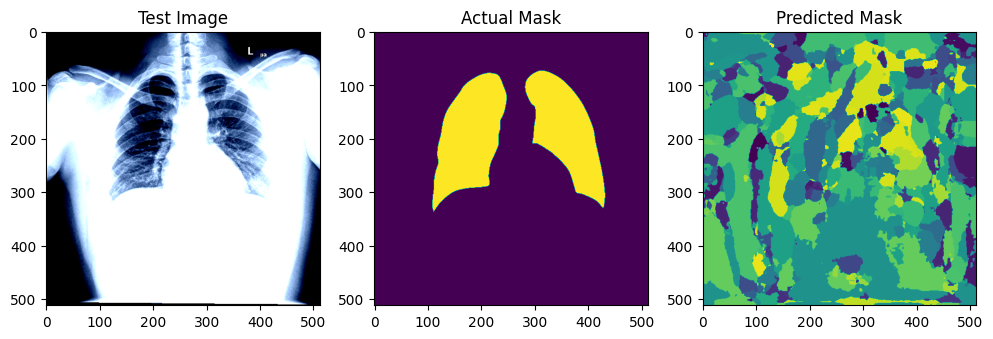

In [ ]:
val_metrics(shenzhen_metrics)
image_display(shenzhen_model, shenzhen_test)

### Part 3: Covid-19 Dataset

In [ ]:
val_metrics(covid_metrics)
image_display(covid_model, covid_test)

Validation Metrics: IoU: 0.5670235187731149, Accuracy: 0.7491341269477296, Precision: 0.5670235187731149, Recall: 0.7491341269477296, F1 Score: 0.6439514189280622


In [ ]:
# darwin_metrics.to_csv("./results/darwin_segformer.csv", index=False)
# shenzhen_metrics.to_csv("./results/shenzhen_segformer.csv", index=False)
# covid_metrics.to_csv("./results/covid_segformer.csv", index=False)